<a href="https://colab.research.google.com/github/ronsoare/super-project/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import librarys that will be use in this project

In [ ]:
import numpy as np
import os
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
from keras.utils import plot_model
from google.colab import drive
import cv2 as cv
from google.colab.patches import cv2_imshow
from keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

### First experiment

##### Connect our notebook with drive and after load the dataset using ImageDataGenerator()

In [ ]:
drive.mount('./content', force_remount=True)

Mounted at ./content


In [ ]:
!unzip '/content/content/MyDrive/brain.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/brain/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0726.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0727.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0728.jpg  
  inflating: /content/brain/Training/glioma/Tr-gl_0729.jpg  
  inflating: /content/brain/Traini

In [ ]:
batch_size = 32
height = 125
width = 125
channels = 1
rescale = 1 / 255
path_train = '/content/brain/Training'
path_test = '/content/brain/Testing'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale, validation_split=0.2)

In [ ]:
train = datagen.flow_from_directory(path_train, class_mode='categorical',
                                    target_size=(height, width), shuffle=True,
                                    color_mode='grayscale', seed=42, batch_size=batch_size,
                                    classes=['glioma','meningioma','notumor','pituitary'],
                                    subset='training'
                                    )

Found 4571 images belonging to 4 classes.


In [ ]:
valid = datagen.flow_from_directory(path_train, class_mode='categorical',
                                    target_size=(height, width), shuffle=False,
                                    color_mode='grayscale', seed=42, batch_size=batch_size,
                                    classes=['glioma', 'meningioma', 'notumor','pituitary'],
                                    subset='validation')

Found 1141 images belonging to 4 classes.


In [ ]:
test = datagen.flow_from_directory(path_test, class_mode='categorical',
                                   target_size=(height, width), shuffle=False,
                                   color_mode='grayscale', seed=42, batch_size=batch_size,
                                   classes=['glioma', 'meningioma', 'notumor','pituitary']
                                   )

Found 1311 images belonging to 4 classes.


##### Functions that will be useful for us in this project

In [ ]:
def avg_metrics_train_val(history):
  """
    Print average loss and accuracy statistics from a training history.

    Args:
        history (dict): A dictionary containing training history with keys 'loss',
                        'val_loss', 'accuracy', and 'val_accuracy'.

    Returns:
        None: This function only prints out the statistics.

    Example:
        history = {
            'loss': [0.2, 0.1, 0.15, ...],
            'val_loss': [0.25, 0.12, 0.18, ...],
            'accuracy': [0.9, 0.95, 0.92, ...],
            'val_accuracy': [0.88, 0.93, 0.89, ...]
        }
        print_loss_and_accuracy_statistics(history)
    """
  loss_set_train = history.history['loss']
  loss_set_val = history.history['val_loss']
  acc_set_train = history.history['accuracy']
  acc_set_val =history.history['val_accuracy']
  print(f'Loss set train: {np.average(loss_set_train)}')
  print(f'Loss set val: {np.average(loss_set_val)}')
  print(f'Accuracy train: {np.average(acc_set_train)}')
  print(f'Accuracy val: {np.average(acc_set_val)}')

In [ ]:
def plot_metrics(history):
  """
    Plot training and validation accuracy, as well as training and validation loss over epochs.

    Args:
        history (dict): A dictionary containing training history with keys 'loss',
                        'val_loss', 'accuracy', and 'val_accuracy'.

    Returns:
        None: This function only plots the graphs.

    Example:
        history = {
            'loss': [0.2, 0.1, 0.15, ...],
            'val_loss': [0.25, 0.12, 0.18, ...],
            'accuracy': [0.9, 0.95, 0.92, ...],
            'val_accuracy': [0.88, 0.93, 0.89, ...]
        }
        plot_training_history(history)
    """
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='val accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [107]:
def show_some_images(batch, num_images=4):
  """
    Display a grid of grayscale images from a batch.

    Args:
        batch (numpy.ndarray): A batch of images represented as a numpy array.
        num_images (int): The number of images to display. Default is 4.

    Returns:
        None: This function only displays the images.

    Example:
        images_batch = ...  # A batch of grayscale images as a numpy array
        show_some_images(images_batch, num_images=6)
    """
  plt.subplots(1, num_images, figsize=(10,10))
  for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(batch[i], cmap='viridis')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

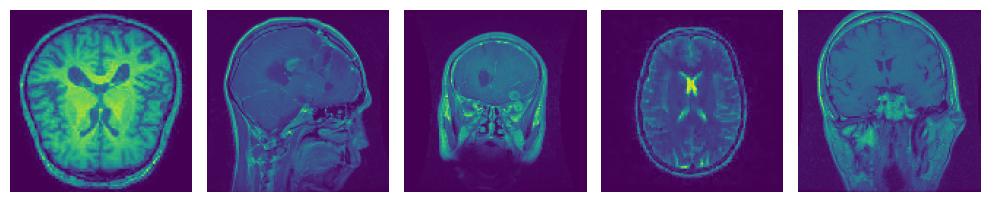

In [108]:
x_batch, y_batch = next(train)
show_some_images(x_batch, num_images=5)

#####Architecture the first model

In [ ]:
model1 = Sequential([
    InputLayer(input_shape=(height, width, channels)),
    Conv2D(125, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(250, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(500, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.5),

    GlobalAveragePooling2D(),

    Dense(500, activation='relu'),
    Dense(250,activation='relu'),
    Dense(125, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 125, 125, 125)     1250      
                                                                 
 average_pooling2d_9 (Averag  (None, 62, 62, 125)      0         
 ePooling2D)                                                     
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 125)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 250)       281500    
                                                                 
 average_pooling2d_10 (Avera  (None, 31, 31, 250)      0         
 gePooling2D)                                                    
                                                                 
 dropout_10 (Dropout)        (None, 31, 31, 250)      

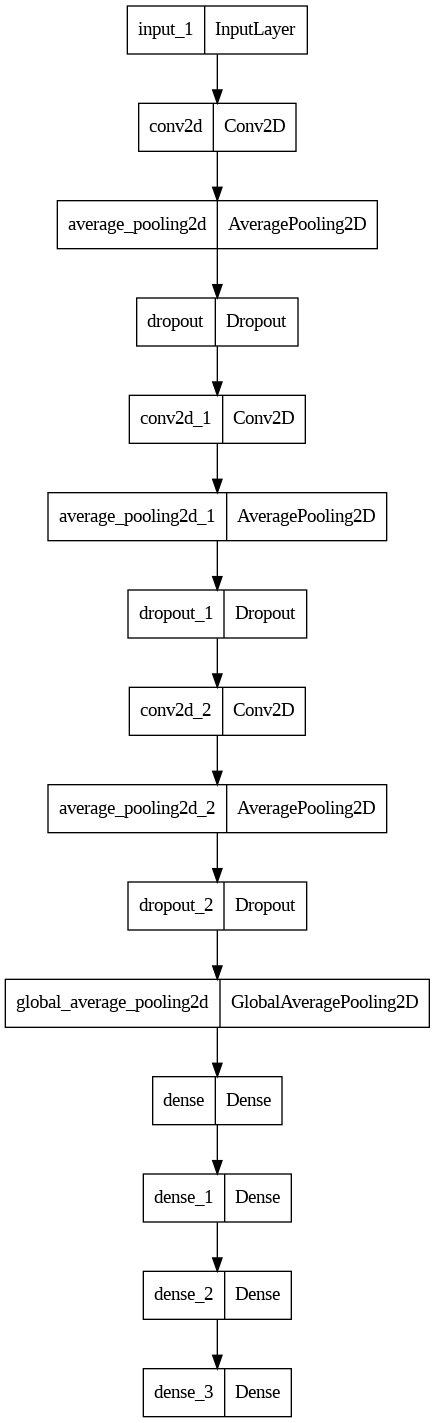

In [ ]:
plot_model(model1)

In [ ]:
tumors = {0:'glioma',1:'meningioma',2:'normal', 3:'pituitaria'}

##### Compile and training the model using the ModelCheckpoint() and EarlyStopping().

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_check = tf.keras.callbacks.ModelCheckpoint(monitor='accuracy', mode='max',
                                                 save_best_only=True, filepath='./model1.h5')
loss_check = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
calls = [model_check, loss_check]

In [ ]:
history1 = model1.fit(train, batch_size=32, epochs=30,
                    validation_data=valid, callbacks=calls)

Epoch 1/30
143/143 [==============================] - 36s 142ms/step - loss: 1.0881 - accuracy: 0.4725 - val_loss: 1.1950 - val_accuracy: 0.5294
Epoch 2/30
143/143 [==============================] - 21s 143ms/step - loss: 0.7449 - accuracy: 0.6935 - val_loss: 0.8723 - val_accuracy: 0.6748
Epoch 3/30
143/143 [==============================] - 18s 123ms/step - loss: 0.5991 - accuracy: 0.7657 - val_loss: 0.7963 - val_accuracy: 0.6705
Epoch 4/30
143/143 [==============================] - 18s 122ms/step - loss: 0.5408 - accuracy: 0.7860 - val_loss: 0.7484 - val_accuracy: 0.7248
Epoch 5/30
143/143 [==============================] - 20s 143ms/step - loss: 0.5019 - accuracy: 0.8005 - val_loss: 0.7363 - val_accuracy: 0.7660
Epoch 6/30
143/143 [==============================] - 17s 121ms/step - loss: 0.4951 - accuracy: 0.8038 - val_loss: 0.6711 - val_accuracy: 0.7572
Epoch 7/30
143/143 [==============================] - 18s 123ms/step - loss: 0.4722 - accuracy: 0.8165 - val_loss: 0.8073 - val_ac

##### Results of the firt model

In [ ]:
avg_metrics_train_val(history1)

Loss set train: 0.47640787892871433
Loss set val: 0.7796759969658322
Accuracy train: 0.809535970290502
Accuracy val: 0.7238290044996474


In [ ]:
model1.evaluate(test)

41/41 [==============================] - 4s 86ms/step - loss: 0.5138 - accuracy: 0.7887


[0.5137913823127747, 0.78871089220047]

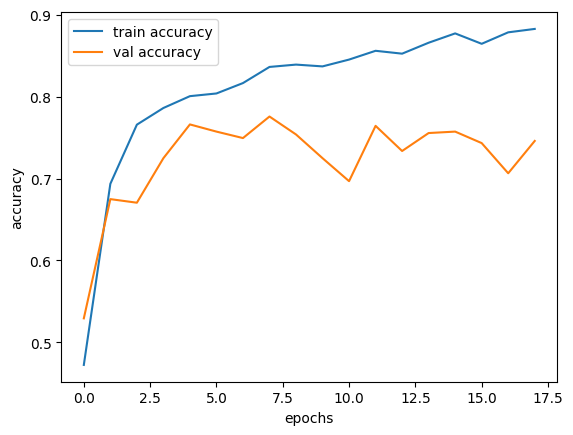

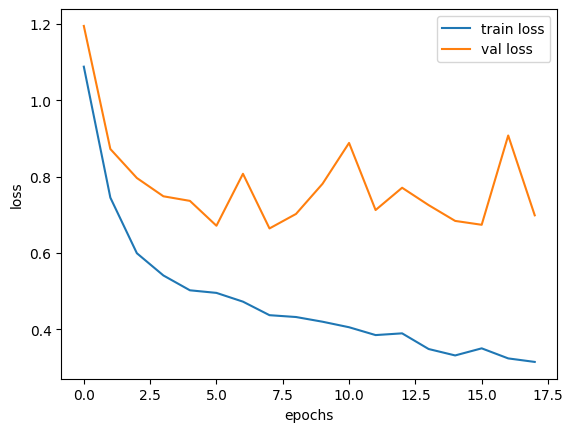

In [ ]:
plot_metrics(history1)

In [ ]:
predict1 = model1.predict(test)
predict1 = np.argmax(predict1, axis=1)
accuracy_score(test.classes, predict1)

41/41 [==============================] - 2s 45ms/step


0.7887109077040427

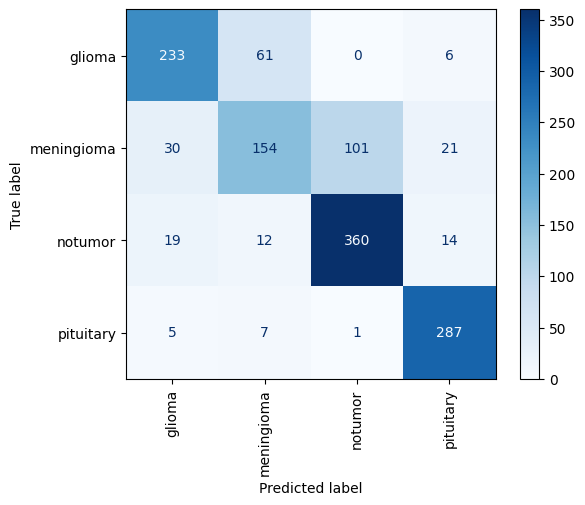

In [ ]:
classes_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(test.classes, predict1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes_names)

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.show()

In [ ]:
print(classification_report(test.classes, predict1, target_names=classes_names))

              precision    recall  f1-score   support

      glioma       0.81      0.78      0.79       300
  meningioma       0.66      0.50      0.57       306
     notumor       0.78      0.89      0.83       405
   pituitary       0.88      0.96      0.91       300

    accuracy                           0.79      1311
   macro avg       0.78      0.78      0.78      1311
weighted avg       0.78      0.79      0.78      1311



This first experiment sugest that the model suffer overffiting: while the loss of the traininig decrease, the val_loss increase along the epochs. Moreover, the curve of accuracy in the val set aren't balance. In addition, our model didn't achive the state of the art the is this task. How can we do for improve the generalization of our model ?

1. Implement data aumentartion
2. Increase the regulariization with l2, l1, or eleatic regularization - elastic can be the best one because made select features as well l1 or lasso regularization.
3. reduce the number of params of our model (neurons for example)
4. Use transfer learning

##### let's take a litle bit look at the 4th layer activation

In [48]:
layers_output = [layer.output for layer in model1.layers[:4]]
len(layers_output)

4

In [49]:
model = tf.keras.Model(inputs= model1.input, outputs=layers_output)

In [46]:
batch_test, y_test_batch = next(test)
print(batch_test.shape, y_test_batch.shape)

(32, 125, 125, 1) (32, 4)


In [52]:
image  = batch_test[0,:,:,0].reshape((1, 125, 125, 1))
image.shape

(1, 125, 125, 1)

In [56]:
y_test_batch[0] # glioma tumor

array([1., 0., 0., 0.], dtype=float32)

In [53]:
activations = model.predict(image)

1/1 [==============================] - 0s 194ms/step


In [58]:
fourth_layer = activations[3] # activation the fourth layer

In [59]:
fourth_layer.shape # activation with just one instance, height and width equals 62 and depth equals 250 (feature maps)

(1, 62, 62, 250)

In [104]:
# let's take a look at some feature maps of the fourth layer
def get_feature_maps(activation_layer, num_features = 8):
  """
    Extracts a specified number of feature maps from an activation layer.

    This function takes an activation layer tensor and extracts a specified number
    of feature maps from it. Each feature map corresponds to a specific channel
    within the activation layer tensor.

    Args:
        activation_layer (numpy.ndarray): The activation layer tensor from which
            feature maps will be extracted. It should be a 4-dimensional array
            with dimensions (batch_size, height, width, num_channels).
        num_features (int, optional): The number of feature maps to extract. Default is 8.

    Returns:
        numpy.ndarray: A 3-dimensional array containing the extracted feature maps.
            The dimensions are (num_features, height, width), where `num_features`
            is the specified number of feature maps, and `height` and `width` are
            the dimensions of each feature map.
    """
  feature_maps = []
  for index in range(num_features):
    feature_maps.append(activation_layer[0,:,:,index+3])

  return np.array(feature_maps)

feature_maps = get_feature_maps(fourth_layer)
feature_maps.shape

(8, 62, 62)

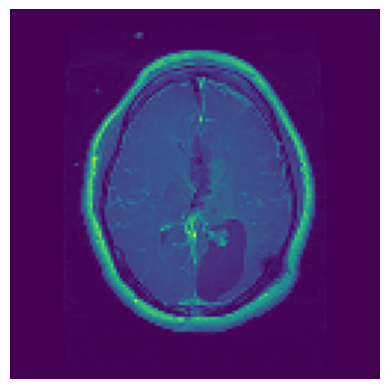

In [105]:
plt.imshow(image[0,:,:,0], cmap='viridis')
plt.axis('off')
plt.show()

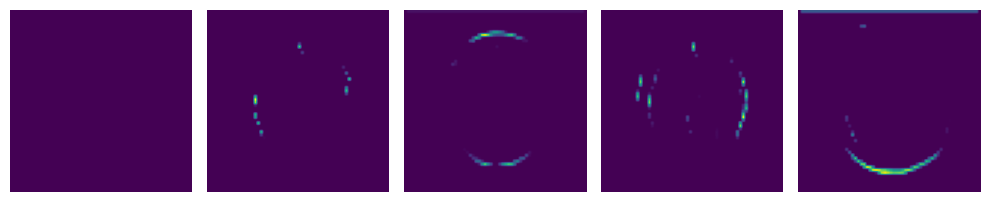

In [109]:
show_some_images(feature_maps, num_images = 5)